In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import wandb

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

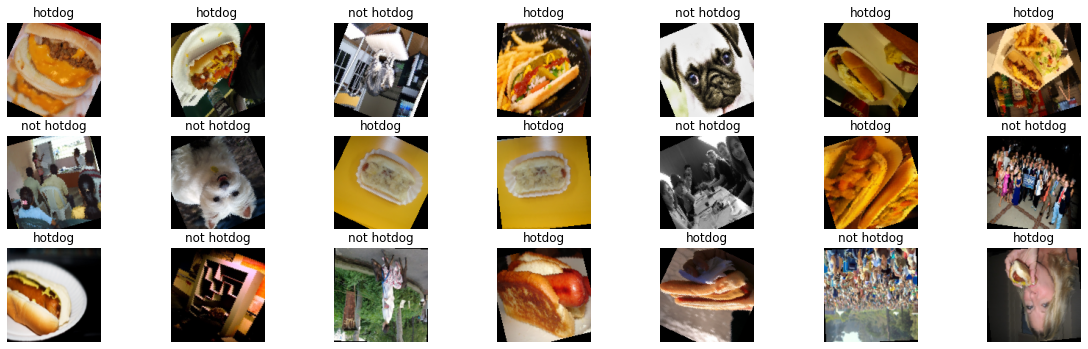

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = nn.CrossEntropyLoss()
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
        wandb.log({"train_acc": out_dict['train_acc'][-1],
                  "test_acc": out_dict['test_acc'][-1],
                  "train_loss": out_dict['train_loss'][-1],
                   "test_loss": out_dict['test_loss'][-1]})      
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 7:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [7]:
model_SGD = models.resnet18(pretrained=False)
num_ftrs = model_SGD.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_SGD.fc = nn.Linear(num_ftrs, 2)

model_ADAM = models.resnet18(pretrained=False)
num_ftrs = model_ADAM.fc.in_features
model_ADAM.fc = nn.Linear(num_ftrs, 2)

model_pre_SGD = models.resnet18(pretrained=True)
num_ftrs = model_pre_SGD.fc.in_features
model_pre_SGD.fc = nn.Linear(num_ftrs, 2)

model_pre_ADAM = models.resnet18(pretrained=True)
num_ftrs = model_pre_ADAM.fc.in_features
model_pre_ADAM.fc = nn.Linear(num_ftrs, 2)

model_SGD.to(device)
model_ADAM.to(device)
model_pre_SGD.to(device)
model_pre_ADAM.to(device)

#Initialize the optimizer
SGD_lr = 0.001
ADAM_lr = 0.000005
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=SGD_lr)
optimizer_ADAM = torch.optim.Adam(model_ADAM.parameters(),lr=ADAM_lr)

#Initialize the optimizer
pre_SGD_lr = 0.001
pre_ADAM_lr = 0.00001
optimizer_pre_SGD = torch.optim.SGD(model_pre_SGD.parameters(), lr=pre_SGD_lr)
optimizer_pre_ADAM = torch.optim.Adam(model_pre_ADAM.parameters(),lr=pre_ADAM_lr)

num_epoch = 30

wandb: Currently logged in as: gizemggungor. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.716	 test: 0.698	 Accuracy train: 45.7%	 test: 51.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.683	 test: 0.690	 Accuracy train: 54.9%	 test: 53.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.670	 test: 0.677	 Accuracy train: 59.4%	 test: 58.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.659	 test: 0.668	 Accuracy train: 62.2%	 test: 59.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.646	 test: 0.668	 Accuracy train: 63.1%	 test: 59.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.637	 test: 0.657	 Accuracy train: 64.4%	 test: 60.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.632	 test: 0.666	 Accuracy train: 65.0%	 test: 60.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.621	 test: 0.647	 Accuracy train: 66.4%	 test: 62.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.620	 test: 0.650	 Accuracy train: 66.4%	 test: 60.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.618	 test: 0.638	 Accuracy train: 66.0%	 test: 63.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.608	 test: 0.625	 Accuracy train: 66.9%	 test: 65.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.601	 test: 0.631	 Accuracy train: 68.3%	 test: 65.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.599	 test: 0.636	 Accuracy train: 69.1%	 test: 64.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.596	 test: 0.628	 Accuracy train: 69.1%	 test: 65.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.593	 test: 0.615	 Accuracy train: 69.3%	 test: 66.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.604	 Accuracy train: 69.9%	 test: 67.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.588	 test: 0.621	 Accuracy train: 69.3%	 test: 66.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.582	 test: 0.611	 Accuracy train: 69.8%	 test: 67.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.580	 test: 0.596	 Accuracy train: 70.6%	 test: 69.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.573	 test: 0.603	 Accuracy train: 70.6%	 test: 68.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.569	 test: 0.594	 Accuracy train: 70.9%	 test: 69.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.569	 test: 0.587	 Accuracy train: 71.0%	 test: 69.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.564	 test: 0.586	 Accuracy train: 72.1%	 test: 70.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.562	 test: 0.589	 Accuracy train: 70.9%	 test: 69.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.563	 test: 0.575	 Accuracy train: 71.6%	 test: 70.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.552	 test: 0.590	 Accuracy train: 72.4%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.545	 test: 0.568	 Accuracy train: 73.7%	 test: 72.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.547	 test: 0.576	 Accuracy train: 73.6%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.539	 test: 0.563	 Accuracy train: 74.3%	 test: 72.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.539	 test: 0.561	 Accuracy train: 74.5%	 test: 72.2%


test_acc,▁▂▃▄▄▄▄▅▄▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
test_loss,██▇▆▆▆▆▅▆▅▄▅▅▄▄▃▄▄▃▃▃▂▂▂▂▃▁▂▁▁
train_acc,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
test_acc,0.72234
test_loss,0.56103
train_acc,0.74499
train_loss,0.53873


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.682	 test: 0.692	 Accuracy train: 55.7%	 test: 52.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.638	 test: 0.640	 Accuracy train: 65.0%	 test: 66.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.614	 test: 0.624	 Accuracy train: 68.1%	 test: 67.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.601	 test: 0.622	 Accuracy train: 69.7%	 test: 67.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.589	 test: 0.600	 Accuracy train: 70.4%	 test: 69.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.585	 test: 0.607	 Accuracy train: 70.8%	 test: 69.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.566	 test: 0.582	 Accuracy train: 72.2%	 test: 70.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.553	 test: 0.571	 Accuracy train: 73.2%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.550	 test: 0.579	 Accuracy train: 73.9%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.534	 test: 0.551	 Accuracy train: 74.9%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.557	 Accuracy train: 74.8%	 test: 73.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.534	 Accuracy train: 75.5%	 test: 73.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.503	 test: 0.531	 Accuracy train: 76.8%	 test: 73.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.492	 test: 0.534	 Accuracy train: 76.9%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.490	 test: 0.522	 Accuracy train: 76.6%	 test: 74.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.475	 test: 0.528	 Accuracy train: 78.2%	 test: 75.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.465	 test: 0.514	 Accuracy train: 78.4%	 test: 74.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.464	 test: 0.511	 Accuracy train: 78.3%	 test: 74.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.464	 test: 0.515	 Accuracy train: 78.6%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.465	 test: 0.528	 Accuracy train: 78.2%	 test: 75.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.450	 test: 0.505	 Accuracy train: 79.3%	 test: 75.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.439	 test: 0.504	 Accuracy train: 80.2%	 test: 75.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.509	 Accuracy train: 80.2%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.436	 test: 0.500	 Accuracy train: 80.3%	 test: 75.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.433	 test: 0.500	 Accuracy train: 79.6%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.432	 test: 0.497	 Accuracy train: 80.3%	 test: 76.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.426	 test: 0.509	 Accuracy train: 80.7%	 test: 76.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.430	 test: 0.494	 Accuracy train: 81.3%	 test: 76.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.432	 test: 0.493	 Accuracy train: 80.3%	 test: 76.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.416	 test: 0.494	 Accuracy train: 82.0%	 test: 76.2%


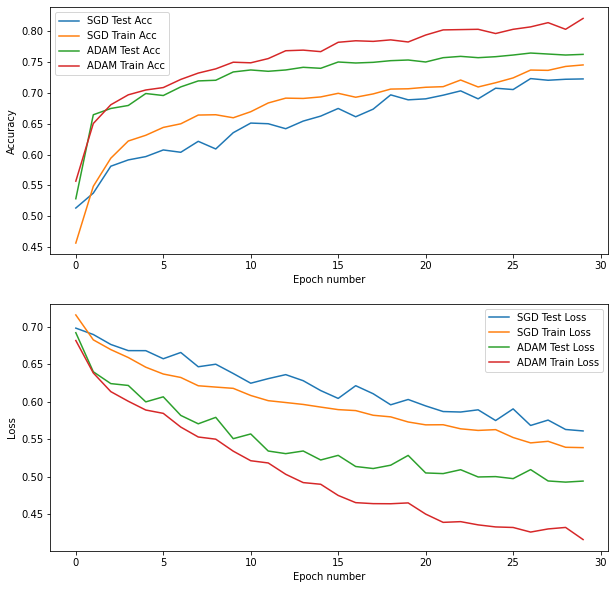

In [8]:
wandb.init(project="Hotdog", name="SGD", entity="gizemggungor")
wandb.config.update({
  "learning_rate": SGD_lr,
  "epochs": num_epoch,
  "optimizer" : "SGD",
  "predefined" : False,
  "data_augmentation" : True  
})

out_dict = train(model_SGD, optimizer_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')


ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

wandb.init(project="Hotdog", name="ADAM", entity="gizemggungor")
wandb.config.update({
  "learning_rate": ADAM_lr,
  "epochs": num_epoch,
  "optimizer" : "ADAM",
  "predefined" : False,
  "data_augmentation" : True   
})
out_dict = train(model_ADAM, optimizer_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()

test_acc,▁▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████████████
test_loss,█▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁
train_acc,▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███▇█████
train_loss,█▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
test_acc,0.76208
test_loss,0.49404
train_acc,0.82022
train_loss,0.41589


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.627	 test: 0.548	 Accuracy train: 64.2%	 test: 72.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.516	 test: 0.463	 Accuracy train: 75.6%	 test: 78.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.472	 test: 0.421	 Accuracy train: 78.4%	 test: 81.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.418	 test: 0.391	 Accuracy train: 80.8%	 test: 82.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.403	 test: 0.373	 Accuracy train: 83.1%	 test: 83.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.380	 test: 0.356	 Accuracy train: 83.6%	 test: 84.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.358	 test: 0.344	 Accuracy train: 84.5%	 test: 85.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.340	 test: 0.339	 Accuracy train: 85.7%	 test: 85.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.326	 test: 0.324	 Accuracy train: 86.5%	 test: 86.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.333	 test: 0.316	 Accuracy train: 86.2%	 test: 86.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.318	 test: 0.314	 Accuracy train: 86.2%	 test: 87.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.304	 test: 0.303	 Accuracy train: 88.0%	 test: 87.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.286	 test: 0.300	 Accuracy train: 88.5%	 test: 87.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.294	 test: 0.292	 Accuracy train: 87.7%	 test: 87.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.284	 test: 0.290	 Accuracy train: 87.5%	 test: 87.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.274	 test: 0.285	 Accuracy train: 89.2%	 test: 88.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.285	 test: 0.282	 Accuracy train: 87.6%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.267	 test: 0.278	 Accuracy train: 88.5%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.258	 test: 0.276	 Accuracy train: 89.9%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.258	 test: 0.270	 Accuracy train: 88.8%	 test: 88.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.255	 test: 0.269	 Accuracy train: 90.1%	 test: 88.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.248	 test: 0.267	 Accuracy train: 89.4%	 test: 89.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.252	 test: 0.264	 Accuracy train: 89.6%	 test: 89.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.252	 test: 0.263	 Accuracy train: 89.7%	 test: 89.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.240	 test: 0.263	 Accuracy train: 89.9%	 test: 89.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.238	 test: 0.260	 Accuracy train: 90.2%	 test: 89.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.231	 test: 0.257	 Accuracy train: 90.4%	 test: 89.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.224	 test: 0.257	 Accuracy train: 90.8%	 test: 89.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.224	 test: 0.256	 Accuracy train: 91.1%	 test: 89.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.216	 test: 0.254	 Accuracy train: 91.8%	 test: 89.5%


test_acc,▁▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
test_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇██████
train_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
test_acc,0.89474
test_loss,0.25361
train_acc,0.91793
train_loss,0.21606


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.606	 test: 0.483	 Accuracy train: 65.9%	 test: 77.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.380	 Accuracy train: 83.0%	 test: 83.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.343	 test: 0.334	 Accuracy train: 85.5%	 test: 85.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.307	 test: 0.305	 Accuracy train: 87.6%	 test: 87.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.275	 test: 0.288	 Accuracy train: 88.3%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.258	 test: 0.279	 Accuracy train: 89.4%	 test: 88.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.238	 test: 0.269	 Accuracy train: 90.6%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.226	 test: 0.257	 Accuracy train: 90.3%	 test: 89.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.220	 test: 0.254	 Accuracy train: 91.2%	 test: 89.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.198	 test: 0.250	 Accuracy train: 92.1%	 test: 90.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.184	 test: 0.247	 Accuracy train: 92.7%	 test: 90.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.180	 test: 0.242	 Accuracy train: 93.3%	 test: 90.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.173	 test: 0.237	 Accuracy train: 93.2%	 test: 90.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.163	 test: 0.234	 Accuracy train: 93.6%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.150	 test: 0.231	 Accuracy train: 94.1%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.148	 test: 0.231	 Accuracy train: 94.4%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.136	 test: 0.228	 Accuracy train: 95.3%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.126	 test: 0.224	 Accuracy train: 95.4%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.134	 test: 0.225	 Accuracy train: 95.3%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.121	 test: 0.223	 Accuracy train: 95.7%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.098	 test: 0.223	 Accuracy train: 97.0%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.097	 test: 0.223	 Accuracy train: 97.1%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.103	 test: 0.227	 Accuracy train: 96.5%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.094	 test: 0.222	 Accuracy train: 96.5%	 test: 91.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.090	 test: 0.219	 Accuracy train: 97.1%	 test: 91.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.093	 test: 0.218	 Accuracy train: 96.4%	 test: 91.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.078	 test: 0.221	 Accuracy train: 97.6%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.081	 test: 0.221	 Accuracy train: 97.1%	 test: 91.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.065	 test: 0.221	 Accuracy train: 98.1%	 test: 91.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.068	 test: 0.222	 Accuracy train: 97.8%	 test: 91.2%


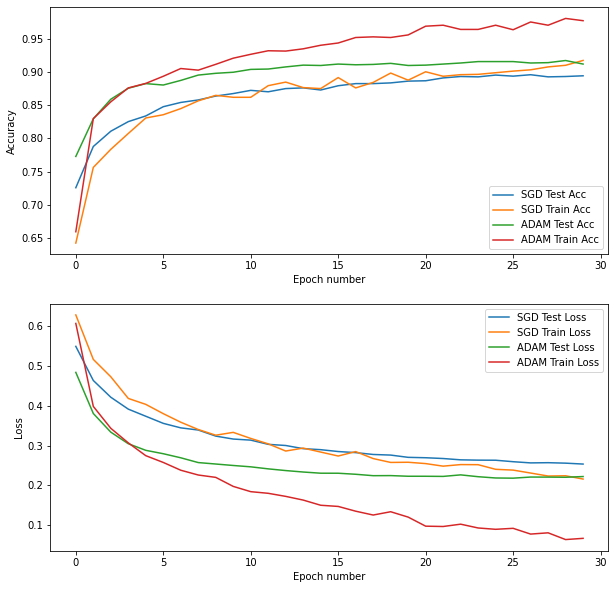

In [9]:
wandb.init(project="Hotdog", name="pre_SGD", entity="gizemggungor")
wandb.config.update({
  "learning_rate": pre_SGD_lr,
  "epochs": num_epoch,
  "optimizer" : "SGD",
  "predefined" : True,
  "data_augmentation" : True  
})

out_dict = train(model_pre_SGD, optimizer_pre_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')


ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

wandb.init(project="Hotdog", name="pre_ADAM", entity="gizemggungor")
wandb.config.update({
  "learning_rate": pre_ADAM_lr,
  "epochs": num_epoch,
  "optimizer" : "ADAM",
  "predefined" : True,
  "data_augmentation" : True  
})
out_dict = train(model_pre_ADAM, optimizer_pre_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()